# Neural ODEs

In [1]:
from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Computing derivatives in ODEs

Let $\mathbf{z} \in \mathbb{R}^N$ whose dynamics evolve according to the [ordinary differential equation](https://mathworld.wolfram.com/OrdinaryDifferentialEquation.html)

$$ \frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t), $$

where $\mathbf{\theta} \in \mathbb{R}^P$ and let $L : \mathbb{R}^N \to \mathbb{R}$. We want to compute the derivatives of the loss $L$ with respect to the parameters $\mathbf{\theta}$. One way to do this would be to solve numerically for $\mathbf{z}(t_1)$ and then backpropagate through the numerical integration routine. Numerical integration routines like [Runge Kutta](https://mathworld.wolfram.com/Runge-KuttaMethod.html) involve only summations and evaluations of $\mathbf{f}$, so we could implement such an algorithm using an automatic differentiation library, run the numerical integration forwards, and then backpropagate through it. However, this requires that we retain the intermediate values of $\mathbf{z}(t)$ that the solver used during integration, which would incur a memory cost of $\mathcal{O}(T)$ where $T = t_1 - t_0$.

The Neural ODE paper proposes first solving the ODE foward from $t_0$ to $t_1$, and then setting up a new differential equation which when solved backwards from $t_1$ to $t_0$ will give us the derivatives of $L$ w.r.t. $\mathbf{\theta}.$ This has two convenient implications. First, we do not need to retain the intermediate $\mathbf{z}$ in memory, because we won't be backpropagating through the ODE solver. Second, we can use off-the-shelf numerical integrators to solve this new backward equation. So there is no need to implement a new solver that supports automatic differentiation.

Let's look at the details of this method, which hinges on two key insights. First, we define the adjoint, which we will use to set up the backward equation.

<div class='definition'>

**Definition (Adjoint)** Given $\mathbf{z}(t) \in \mathbb{R}^N$ for $t \in [t_0, t_1]$ and a function $L : \mathbb{R}^N \to \mathbb{R}$, the adjoint is defined as
    
$$ \mathbf{a}(t) = \frac{\partial L}{\partial \mathbf{z}(t)}. $$
    
</div>
<br>

The first piece of insight is that the adjoint itself obeys a differential equation, stated and proved below.

<div class='theorem'>

**Result (Differential equation of the adjoint)** Given an ODE of the form
    
$$\frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t),$$
    
the adjoint $\mathbf{a}(t)$ obeys the differential equation

$$ \frac{d \mathbf{a}}{dt} = - \frac{\partial \mathbf{f}}{\partial \mathbf{z}} \mathbf{a},$$
    
</div>
<br>


<details class="proof">
<summary>Proof: Differential equation of the adjoint</summary>

<div>
    
Starting from the relation
    
$$\begin{align}
\mathbf{a}(t) &= \frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} \frac{d L}{d \mathbf{z}(t + \epsilon)} \\
&= \frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} \mathbf{a}(t + \epsilon),
\end{align}$$
    
we substitute the following identity
    
$$ \begin{align}
\frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} &= \frac{\partial}{\partial \mathbf{z}} \int_t^{t + \epsilon} \mathbf{f}(\mathbf{z}, t) dt \\
&= \mathbf{I} + \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2),
\end{align}$$
    
to obtain the relation
    
$$\begin{align}
\mathbf{a}(t) = \left[ \mathbf{I} + \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2) \right] \mathbf{a}(t + \epsilon),
\end{align}$$
    
Now we write the change in $\mathbf{a}$ from $t$ to $t + \epsilon$ as
    
$$\begin{align}
\mathbf{a}(t + \epsilon) - \mathbf{a}(t) = \left[ - \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2) \right] \mathbf{a}(t + \epsilon).
\end{align}$$
    
Dividing by $\epsilon$ and taking the limit $\epsilon \to 0$ we arrive at
    
$$\begin{align}
\frac{d \mathbf{a}}{d t} = - \frac{\partial \mathbf{f}}{\partial \mathbf{z}} \mathbf{a},~~\text{ where } \left(\frac{\partial \mathbf{f}}{\partial \mathbf{z}}\right)_{ij} = \frac{\partial f_j}{\partial z_i}.
\end{align}$$
 
</div>

</details>
<br>

Now if we integrate the differential equation of the adjoint we obtain

$$ \begin{align}
\frac{d L}{d \mathbf{z}(t)} = \mathbf{a}(T) + \int_t^T \frac{d \mathbf{f}}{d \mathbf{z}} \mathbf{a}~dt.
\end{align}$$

It would be great if in addition to $\frac{d L}{d \mathbf{z}(t)}$ we could also compute $\frac{d L}{d \mathbf{\theta}}$ in a similar way. This is where the second piece of insight comes in. If we append $\mathbf{\theta}$ to the state vector $\mathbf{z}$ to obtain the augmented state

$$ \begin{align}
\mathbf{z}_{aug} = \begin{bmatrix}\mathbf{z} \\ \mathbf{\theta} \end{bmatrix},
\end{align}$$

and let this evolve accoding to the ODE

$$ \begin{align}
\frac{d \mathbf{z}_{aug}}{d t} = \mathbf{f}_{aug}(\mathbf{z}_{aug}, \mathbf{\theta}, t),~~\text{ where }~~\mathbf{f}_{aug} = \begin{bmatrix}\mathbf{f} \\ 0 \end{bmatrix},
\end{align}$$

then the augmented adjoint obeys

$$ \frac{d \mathbf{a}_{aug}}{dt} = - \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} \mathbf{a}_{aug}. $$

We can then integrate this equation in precisely the same way as above to obtain

$$ \begin{align}
\frac{d L}{d \mathbf{z}_{aug}(t)} \equiv \left[\frac{d L}{d \mathbf{z}(t)}, \frac{d L}{d \mathbf{\theta}}\right] = \mathbf{a}_{aug}(T) + \int_t^T \frac{d \mathbf{f}_{aug}}{d \mathbf{z}_{aug}} \mathbf{a}_{aug}~dt,
\end{align}$$

arriving at the derivative $\frac{d L}{d \mathbf{\theta}}$ which are after. In practice, when solving backwards for the above intetgral, we will require $\mathbf{z}$ at each step of the solve. Putting this together with the forward solve we have the following algorithm, called the adjoint sensitivity method.


<div class='definition'>

**Definition (ODE gradients with the adjoint sensitivity method)** Given $\mathbf{z}(t) \in \mathbb{R}^N, t \in [t_0, t_1]$ evolving according to 
  
$$ \frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t), $$
    
where $\mathbf{\theta} \in \mathbb{R}^P$ and let $L : \mathbb{R}^N \to \mathbb{R}$, with the initial condition $\mathbf{z}_0$ and a function $L : \mathbb{R}^N \to \mathbb{R}$, the adjoint sensitivity method computes the derivatives of $L$ w.r.t. $\mathbf{\theta}$ in two steps:
    
1. Solve the above ODE for $\mathbf{z}(t_1) = \mathbf{z}_1$ and compute $\mathbf{a}(t_1) = \mathbf{a}_1$.
2. Solve the following ODE from time $t = t_1$ to $t = t_0$
    
$$\begin{align}
\frac{d}{d t} \begin{bmatrix} \mathbf{z} \\ \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} \mathbf{f} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}, \text{ with init. cond. } \left[\mathbf{z}_1, \mathbf{a}_1, \mathbf{\theta} \right].
\end{align}$$
    
</div>
<br>



<details class="proof">
<summary>Derivation: ODE gradients with the adjoint sensitivity method</summary>
    
Here we derive the ODE in the second step of the above algorithm. The matrix $\partial \mathbf{f}_{aug} / \partial \mathbf{z}_{aug}$ in the expression
    
$$ \frac{d \mathbf{a}_{aug}}{dt} = - \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} \mathbf{a}_{aug}. $$

is given by the following expression 

$$ \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} = \begin{bmatrix}
\frac{d\mathbf{f}}{d\mathbf{z}} & \mathbf{0}  \\
\frac{d\mathbf{f}}{d\mathbf{\theta}} & \mathbf{0}  \end{bmatrix}.$$

Hence, the augmented adjoint obeys

$$ \begin{align}
\frac{d \mathbf{a}_{aug}}{d t} = \frac{d}{d t} \begin{bmatrix} \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}.
\end{align}$$

In order to evaluate the expression on the RHS at any time $t$ during the backward solve, we will need to know $\mathbf{z}(t)$. We therefore explicitly include the evolution of $\mathbf{z}$ in the ODE, arriving at the ODE problem
    
$$\begin{align}
\frac{d}{d t} \begin{bmatrix} \mathbf{z} \\ \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} \mathbf{f} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}, \text{ with init. cond. } \left[\mathbf{z}_1, \mathbf{a}_1, \mathbf{\theta} \right].
\end{align}$$

</details>
<br>

## Visualising trajectories

Before implementing this algorithm, let's have a look at what the trajecotries from our model may look like. Let's set $\mathbf{f}$ to be a neural network with a single hidden layer, with randomly initialised weights.

In [2]:
import numpy as np
from scipy.integrate import ode as ODE
from matplotlib import pyplot as plt

In [3]:
class TransitionDynamics:
    
    def __init__(self, hidden_size, state_size):
        
        self.W1 = np.random.normal(size=(hidden_size, state_size),
                                   loc=0,
                                   scale=state_size**-0.5)
        
        self.b1 = np.random.normal(size=(hidden_size,))
        
        self.W2 = np.random.normal(size=(state_size, hidden_size),
                                   loc=0,
                                   scale=hidden_size**-0.5)
        
        self.b2 = np.random.normal(size=(state_size,))
        
    
    def __call__(self, t, x):
        
        assert len(x.shape) == 1
        
        x = np.dot(self.W1, x)
        x = x + self.b1
        
        x = np.tanh(x)
        
        x = np.dot(self.W2, x)
        x = x + self.b2
        
        return x

Now we sample nine such models (each corresponding to one of the squares below). For each model we sample initial points uniformly at random, and solve the ODE defined by the model forwards, to obtain the trajectories shown.

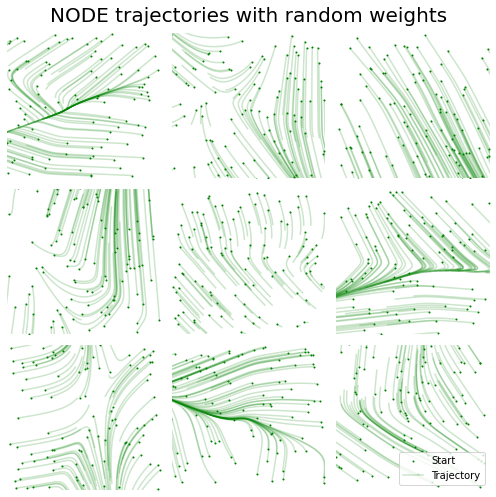

In [4]:
# Set random seed to sample same weights each time
np.random.seed(1)

# Set integration parameters
t0 = 0.
t1 = 10.
num_traj = 100
num_steps = 50
dt = t1 / num_steps

# Hidden size for transition dynamics
hidden_size = 3

# Set state size to 2 for 2D plots
state_size = 2

# Simulate and plot
plt.figure(figsize=(7, 7))

for i in range(9):

    plt.subplot(3, 3, i + 1)

    # New transition dynamics with random weights
    transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

    for seed in range(num_traj):

        # Sample initial states
        y0 = 20 * (np.random.rand(2) - 0.5)

        # Array to store states
        states = np.zeros(shape=(0, 2))

        # Set ODE integrator
        ode = ODE(f=transition_dynamics.__call__).set_integrator('vode')
        ode = ode.set_initial_value(y0, t0)

        # Integrate numerically within time interval
        while ode.successful() and ode.t < t1:
            states = np.concatenate([states, ode.integrate(ode.t + dt)[None, :]], axis=0)
            
        # Plot starting point and trajectory
        s = plt.scatter(states[0, 0], states[0, 1], color='green', marker='o', s=1, zorder=2)
        p, = plt.plot(states[:, 0], states[:, 1], color='green', alpha=0.2, zorder=1)
        
        if i == 8 and seed == 0: plt.legend([s, p], ['Start', 'Trajectory'], loc='lower right')
    
    plt.axis('off')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    
plt.suptitle('NODE trajectories with random weights', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Differentiable transition funcion

To apply the adjoint sensitivity method, we will have to differentiate through the transition function $\mathbf{f}$ as well as the loss function $L$. We'll therefore impement the NODE as a tensorflow module.

$$\begin{align}
\frac{d}{d t} \begin{bmatrix} \mathbf{z} \\ \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} \mathbf{f} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}, \text{ with init. cond. } \left[\mathbf{z}_1, \mathbf{a}_1, \mathbf{\theta} \right].
\end{align}$$

In [731]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp

tfd = tfp.distributions


class NODE(tf.Module):
    
    def __init__(self, hidden_size, state_size, dtype, name='node'):
        
        super().__init__()
        
        self.dtype = dtype
        
        self.state_size = state_size
        
        self.W1 = tf.random.normal(shape=(state_size, hidden_size),
                                   mean=0.,
                                   stddev=state_size**-0.5,
                                   dtype=dtype)
        self.W1 = tf.Variable(self.W1)
        
        self.b1 = tf.random.normal(shape=(1, hidden_size),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b1 = tf.Variable(self.b1)
        
        self.W2 = tf.random.normal(shape=(hidden_size, state_size),
                                   mean=0,
                                   stddev=hidden_size**-0.5,
                                   dtype=dtype)
        self.W2 = tf.Variable(self.W2)
        
        self.b2 = tf.random.normal(shape=(1, state_size),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b2 = tf.Variable(self.b2)
        
    
    def f(self, t, z):
        
        z = tf.convert_to_tensor(z, dtype=self.dtype)
        z = tf.reshape(z, (-1, self.state_size))
        
        f = tf.einsum('ni, ij -> nj', z, self.W1)
        f = f + self.b1
        
        f = tf.cast(tf.tanh(f), dtype=self.dtype)
        
        f = tf.einsum('ni, ij -> nj', f, self.W2)
        f = f + self.b2
        
        return f
    
    
    def backward_dynamics(self, t, za):
        """
        params za : tf.tensor, concatenated state and adjoint (B * (2 * Z + P),)
        
        returns tensor of shape (B * (2 * Z + P),)
        """
        
        num_params = tf.reduce_sum([tf.reduce_prod(tensor.shape) for tensor in self.trainable_variables])
        last_dim = 2 * self.state_size + num_params
        
        za = tf.convert_to_tensor(za, dtype=self.dtype)
        za = tf.reshape(za, (-1, last_dim))
        
        z = za[:, :self.state_size] # (B, Z)
        a = za[:, self.state_size:2*self.state_size] # (B, Z)
        
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(z)
            tape.watch(self.trainable_variables)

            f = self.f(t, z)
        
        dfdz = tape.batch_jacobian(f, z) # (B, Z, Z) dfdz_ij = (df_i)/dz_j
        dfdz_a = - tf.einsum('nij, ni -> nj', dfdz, a)
        
        dfdtheta = tape.jacobian(f, self.trainable_variables) # list of (B, Z, P[i])
        dfdtheta = [tf.reshape(tensor, (tensor.shape[0], tensor.shape[1], -1)) for tensor in dfdtheta]
        dfdtheta_a = [- tf.einsum('nij, ni -> nj', tensor, a) for tensor in dfdtheta]
        
        augmented_dynamics = tf.concat([f, dfdz_a] + dfdtheta_a, axis=1)
        
        return augmented_dynamics
    
    
    def loglik(self, zpred, zdata):
        """
        params zpred : tf.tensor, predicted state (B, Z)
        params zdata : tf.tensor, data state (B, Z)
        
        where (batch_size, state_size) is (B, Z).
        """

        assert zpred.shape == zdata.shape

        dist = tfd.MultivariateNormalDiag(loc=zpred, scale_identity_multiplier=1e0)

        # Loglik of each state dimension, for each datapoint (B, Z)
        loglik = dist.log_prob(zdata)
        
        # Average log likelihood over batch
        loglik = tf.reduce_sum(loglik)

        return loglik
    
    
    def backward_initial_conditions(self, t, z, zdata):
        
        with tf.GradientTape(persistent=True) as tape:
            
            tape.watch(z)
            
            L = - self.loglik(z, zdata)
            
        dLdz = tape.gradient(L, z)
        
        zeros = [tf.zeros(shape=(z.shape[0], tf.reduce_prod(tensor.shape)), dtype=self.dtype) \
                 for tensor in self.trainable_variables]
        
        init_cond = tf.concat([z, dLdz] + zeros, axis=1)
        
        return init_cond
    
    
    def gradients_from_za(self, za):
        
        za_size = 2 * self.state_size + tf.reduce_sum([tf.reduce_prod(variable.shape) for variable in self.variables])
        
        za = tf.convert_to_tensor(za, dtype=self.dtype)
        za = tf.reshape(za, (-1, za_size))
        
        gradients = tf.reduce_sum(za[:, 4:], axis=0)
        
        idx_start = 0
        variable_gradients = []
        
        for variable in self.variables:
            
            variable_shape = variable.shape
            variable_size = tf.reduce_prod(variable_shape)
            
            variable_gradient = gradients[idx_start:idx_start+variable_size]
            variable_gradient = tf.reshape(variable_gradient, variable_shape)
            
            idx_start = idx_start + variable_size
            
            variable_gradients.append(variable_gradient)
        
        return variable_gradients
    
    
    def solve(self, init_cond, t0, t1, dt, atol, forward):
        
        if forward:
            
            f = lambda t, z : tf.reshape(self.f(t, z), (-1,))
            ode = ODE(f=f).set_integrator('vode', atol=atol)
            ode = ode.set_initial_value(np.reshape(init_cond, (-1,)), t0)
            
            while ode.successful:
                solution = ode.integrate(ode.t + dt)
                
                if ode.t > t1: return solution
        
        else:
            
            f = lambda t, za : tf.reshape(self.backward_dynamics(t, za), (-1,))
            ode = ODE(f=f).set_integrator('vode', atol=atol)
            ode = ode.set_initial_value(np.reshape(init_cond, (-1,)), t1)
            
            while ode.successful:
                solution = ode.integrate(ode.t - dt)
                
                if ode.t < t0: return solution

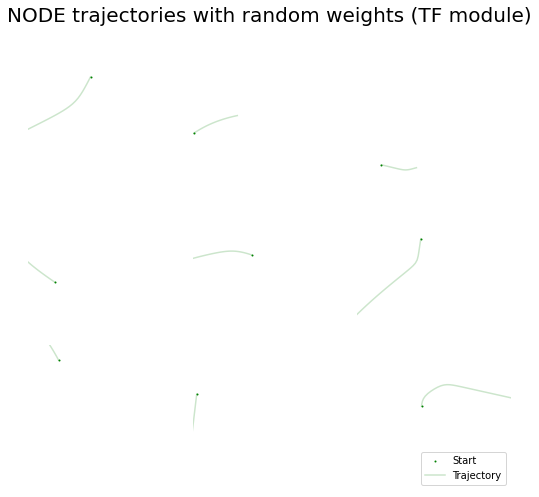

In [732]:
# Set random seed to sample same weights each time
np.random.seed(1)
dtype = tf.float64

# Set integration parameters
t0 = 0.
t1 = 10.
num_traj = 1
num_steps = 50
dt = t1 / num_steps

# Hidden size for transition dynamics
hidden_size = 3

# Set state size to 2 for 2D plots
state_size = 2

# Simulate and plot
plt.figure(figsize=(7, 7))

for i in range(9):

    plt.subplot(3, 3, i + 1)

    # New transition dynamics with random weights
    node = NODE(hidden_size=hidden_size, state_size=state_size, dtype=dtype)
    
    # Random initial states
    z0 = 20 * (np.random.uniform(size=(num_traj, state_size)) - 0.5)
    z0 = tf.convert_to_tensor(z0, dtype=dtype)
    z0 = tf.reshape(z0, (-1,))

    # Set ODE integrator
    ode = ODE(f=lambda t, z : tf.reshape(node.f(t, z), (-1,))).set_integrator('vode')
    ode = ode.set_initial_value(z0, t0)
    
    # For storing intermediate states for plotting
    states = np.zeros(shape=(num_traj, 0, state_size))

    # Integrate numerically within time interval
    while ode.successful() and ode.t < t1:
        next_states = np.reshape(ode.integrate(ode.t + dt), (num_traj, 1, state_size))
        states = np.concatenate([states, next_states], axis=1)
    
    # Plot starting point and trajectory
    s = plt.scatter(states[:, 0, 0], states[:, 0, 1], color='green', marker='o', s=1, zorder=2)
    
    # Plot the trajectories
    for n in range(num_traj):
        p, = plt.plot(states[n, :, 0], states[n, :, 1], color='green', alpha=0.2, zorder=1)
        
        if i == 8 and n == 0: plt.legend([s, p], ['Start', 'Trajectory'], loc='lower right')
    
    plt.axis('off')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    
plt.suptitle('NODE trajectories with random weights (TF module)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [735]:
# Set random seeds and dtype
np.random.seed(0)
tf.random.set_seed(0)
dtype = tf.float32

# Set integration parameters
t0 = 0.
t1 = 10.
num_steps = 50
dt = t1 / num_steps
num_datapoints = 500
atol = 1e-3

# Hidden size for transition dynamics
hidden_size = 3

# Set state size to 2 for 2D plots
state_size = 2

# New transition dynamics with random weights
node = NODE(hidden_size=hidden_size, state_size=state_size, dtype=dtype)

# Initial positions
z0 = 20 * (np.random.uniform(size=(num_datapoints * state_size)) - 0.5)

# Numerical solve for final conditions
z1 = node.solve(z0, t0, t1, dt, atol, forward=True)

In [ ]:
# Change random seeds to draw different model
np.random.seed(1)
tf.random.set_seed(1)

num_train_steps = 200
learning_rate = 1e-3

# New transition dynamics with random weights
node = NODE(hidden_size=hidden_size, state_size=state_size, dtype=dtype)

z1_data = tf.convert_to_tensor(np.reshape(z1, (-1, state_size)), dtype=dtype)

optimiser = tfk.optimizers.Adam(learning_rate=learning_rate)

for i in range(num_train_steps):
    
    z1_pred = node.solve(z0, t0, t1, dt, atol, forward=True)
    
    z1_pred = tf.convert_to_tensor(np.reshape(z1_pred, (-1, state_size)), dtype=dtype)

    za1 = node.backward_initial_conditions(t1, z1_pred, z1_data)
    za1 = tf.reshape(za1, (-1,))
    
    za0 = node.solve(za1, t0, t1, dt, atol, forward=False)
    
    gradients = node.gradients_from_za(za0)
    
    optimiser.apply_gradients(zip(gradients, node.variables))

    print(node.loglik(tf.reshape(z1_pred, shape=(-1, state_size)),
                      tf.reshape(z1_data, shape=(-1, state_size))) / num_datapoints)

tf.Tensor(-283.8621, shape=(), dtype=float32)
tf.Tensor(-282.81958, shape=(), dtype=float32)
tf.Tensor(-281.78, shape=(), dtype=float32)
tf.Tensor(-280.74368, shape=(), dtype=float32)
tf.Tensor(-279.7106, shape=(), dtype=float32)
tf.Tensor(-278.6806, shape=(), dtype=float32)
tf.Tensor(-277.65393, shape=(), dtype=float32)
tf.Tensor(-276.6306, shape=(), dtype=float32)
tf.Tensor(-275.61057, shape=(), dtype=float32)
tf.Tensor(-274.59384, shape=(), dtype=float32)
tf.Tensor(-273.5808, shape=(), dtype=float32)
tf.Tensor(-272.5712, shape=(), dtype=float32)
tf.Tensor(-271.56503, shape=(), dtype=float32)
tf.Tensor(-270.56253, shape=(), dtype=float32)
tf.Tensor(-269.5636, shape=(), dtype=float32)
tf.Tensor(-268.56824, shape=(), dtype=float32)
tf.Tensor(-267.57648, shape=(), dtype=float32)
tf.Tensor(-266.58853, shape=(), dtype=float32)
tf.Tensor(-265.60422, shape=(), dtype=float32)
tf.Tensor(-264.6236, shape=(), dtype=float32)
tf.Tensor(-263.64676, shape=(), dtype=float32)
tf.Tensor(-262.6736, sha